# **Chatbot Pipeline**

In [15]:
pip show langchain

Name: langchain
Version: 0.3.25
Summary: Building applications with LLMs through composability
Home-page: 
Author: 
Author-email: 
License: MIT
Location: c:\Users\mvell\anaconda3\Lib\site-packages
Requires: langchain-core, langchain-text-splitters, langsmith, pydantic, PyYAML, requests, SQLAlchemy
Required-by: langchain-community, ragas
Note: you may need to restart the kernel to use updated packages.


In [1]:
import langchain

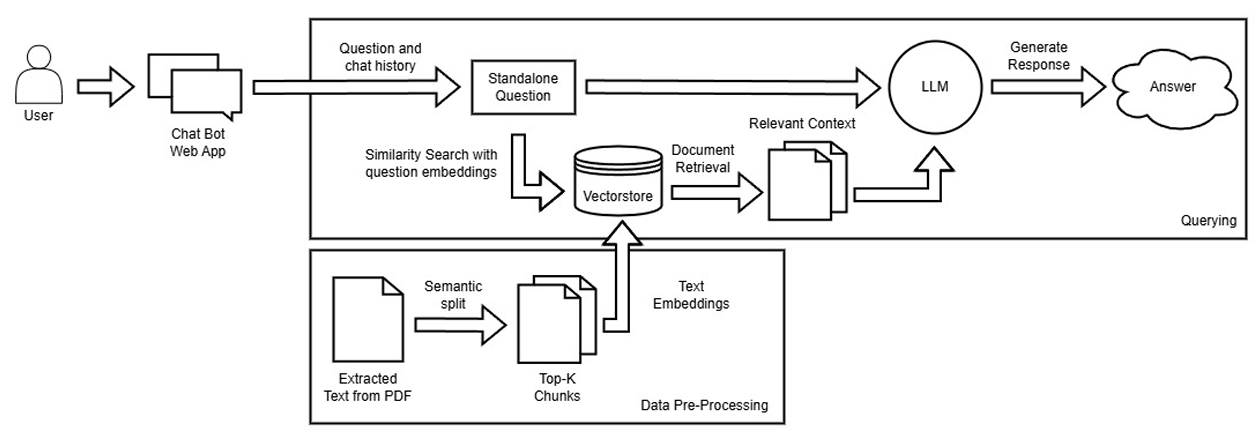

# **Access Google Drive**

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import os
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter #Mengimpor alat untuk memecah teks panjang menjadi bagian-bagian kecil (chunks) berdasarkan panjang karakter.
from typing import List #Untuk deklarasi tipe data list.
from langchain_core.documents import Document #Tipe data dokumen yang digunakan LangChain. (Untuk membantu strukturisasi dokumen.)

# **Extract Text from DOCX or PDF**

In [3]:
# 1. Function to load documents from a folder
def load_documents(folder_path: str) -> List[Document]:
    documents = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Lewati jika bukan file
        if not os.path.isfile(file_path):
            print(f"Skipping non-file: {filename}")
            continue

        if filename.endswith('.pdf'):
            loader = PyPDFLoader(file_path)
        elif filename.endswith('.docx'):
            loader = Docx2txtLoader(file_path)
        else:
            print(f"Unsupported file type: {filename}")
            continue

        try:
            documents.extend(loader.load())
        except Exception as e:
            print(f"Failed to load {filename}: {e}")
    return documents

In [4]:
# 2. Load documents from a folder
folder_path = "rag_dataset" # dataset folder name
documents = load_documents(folder_path)

In [5]:
documents

[Document(metadata={'source': 'rag_dataset\\Dataset_Skripsi.docx'}, page_content='Bab 1\n\nPemerintah telah mengundangkan peraturan terbaru terkait dengan Pemotongan Pajak atas Penghasilan sehubungan dengan Pekerjaan, Jasa, atau Kegiatan Orang Pribadi melalui Peraturan Pemerintah Nomor 58 Tahun 2023 dan Peraturan Menteri Keuangan Nomor 168 Tahun 2023 Terbitnya PP 58/2023 mencabut Pasal 2 ayat (3) PP 80 Tahun 2010. Sementara PMK 168/2023 menggantikan ketentuan lama seperti Peraturan Menteri Keuangan Nomor 250/PMK.03/2008, 252/PMK.03/2008, dan PMK 102/PMK.010/2016, serta mencabut dan mengganti Pasal 5, Pasal 8, Bagian Pertama angka I, Bagian Pertama angka II Lampiran Peraturan Menteri Keuangan Nomor 262/PMK.03/2010. Kehadiran regulasi yang mulai berlaku 1 Januari 2024 ini dilatarbelakangi oleh beberapa alasan, yaitu:\n\nPemotongan PPh Pasal 21 pada ketentuan lama memiliki berbagai skema perhitungan yang dapat membingungkan Wajib Pajak dan secara administrasi memberatkan terutama bagi yan

In [6]:
for i, doc in enumerate(documents[:5]):  # tampilkan 5 dokumen pertama
    print(f"\nDokumen {i+1}")
    print(f"Nama file : {doc.metadata.get('source')}")
    print(f"Isi awal  : {doc.page_content[:300]}")  # tampilkan 300 karakter pertama


Dokumen 1
Nama file : rag_dataset\Dataset_Skripsi.docx
Isi awal  : Bab 1

Pemerintah telah mengundangkan peraturan terbaru terkait dengan Pemotongan Pajak atas Penghasilan sehubungan dengan Pekerjaan, Jasa, atau Kegiatan Orang Pribadi melalui Peraturan Pemerintah Nomor 58 Tahun 2023 dan Peraturan Menteri Keuangan Nomor 168 Tahun 2023 Terbitnya PP 58/2023 mencabut P


# **Split Text in Document into Chunks**

Best Practice text_splitter untuk deepseek-r1:7b

In [7]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,        # Cukup besar, tapi aman untuk reranking dan retrieval
    chunk_overlap=100,      # Untuk jaga konteks antar paragraf
    length_function=len     # Pakai len(), atau tokenizer kalau mau presisi
)

In [8]:
print(f"Loaded {len(documents)} pages from the file.")
splits = text_splitter.split_documents(documents)
print(f"Split the file content into {len(splits)} chunks.")

Loaded 1 pages from the file.
Split the file content into 146 chunks.


In [9]:
import re

for split in splits:
    split.page_content = re.sub(r'\s+', ' ', split.page_content).strip()

In [10]:
splits

[Document(metadata={'source': 'rag_dataset\\Dataset_Skripsi.docx'}, page_content='Bab 1 Pemerintah telah mengundangkan peraturan terbaru terkait dengan Pemotongan Pajak atas Penghasilan sehubungan dengan Pekerjaan, Jasa, atau Kegiatan Orang Pribadi melalui Peraturan Pemerintah Nomor 58 Tahun 2023 dan Peraturan Menteri Keuangan Nomor 168 Tahun 2023 Terbitnya PP 58/2023 mencabut Pasal 2 ayat (3) PP 80 Tahun 2010. Sementara PMK 168/2023 menggantikan ketentuan lama seperti Peraturan Menteri Keuangan Nomor 250/PMK.03/2008, 252/PMK.03/2008, dan PMK 102/PMK.010/2016, serta mencabut dan mengganti Pasal 5, Pasal 8, Bagian Pertama angka I, Bagian Pertama angka II Lampiran Peraturan Menteri Keuangan Nomor 262/PMK.03/2010. Kehadiran regulasi yang mulai berlaku 1 Januari 2024 ini dilatarbelakangi oleh beberapa alasan, yaitu: Pemotongan PPh Pasal 21 pada ketentuan lama memiliki berbagai skema perhitungan yang dapat membingungkan Wajib Pajak dan secara administrasi memberatkan terutama bagi yang beru

In [11]:
len(splits)

146

Mau menggunakan model huggingface

# **Embed the Text from Chunks + Vectorstore**

In [3]:
from sentence_transformers import SentenceTransformer
from langchain_core.embeddings import Embeddings
import torch

class LangchainE5Embedding(Embeddings):
    def __init__(self, model_name="intfloat/multilingual-e5-large", device=None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = SentenceTransformer(model_name, device=self.device)

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        texts = [f"passage: {text}" for text in texts]
        return self.model.encode(texts, normalize_embeddings=True).tolist()

    def embed_query(self, text: str) -> List[float]:
        return self.model.encode(f"query: {text}", normalize_embeddings=True).tolist()

In [4]:
embedding_function = LangchainE5Embedding()

In [5]:
embedding_function = LangchainE5Embedding()
document_embeddings = embedding_function.embed_documents([split.page_content for split in splits])

document_embeddings[0]

NameError: name 'splits' is not defined

In [ ]:
from langchain_chroma import Chroma

# Create Vectorstore
vectorstore = Chroma.from_documents(
    documents=splits,
    embedding=embedding_function,
    persist_directory="./chroma_e5_database",  # pakai folder baru
    collection_name="beetax_collection_v2"
)

In [15]:
vectorstore._collection.count()

146

In [19]:
# Ambil semua dokumen
docs = vectorstore.get(include=["metadatas", "documents", "embeddings"])

# Contoh lihat 3 dokumen pertama
for i in range(min(3, len(docs["documents"]))):
    print(f"\n--- Document {i} ---")
    print("Content:", docs["documents"][i])
    print("Metadata:", docs["metadatas"][i])
    print("Embedding:", docs["embeddings"][i][:5], "...")


--- Document 0 ---
Content: Bab 1 Pemerintah telah mengundangkan peraturan terbaru terkait dengan Pemotongan Pajak atas Penghasilan sehubungan dengan Pekerjaan, Jasa, atau Kegiatan Orang Pribadi melalui Peraturan Pemerintah Nomor 58 Tahun 2023 dan Peraturan Menteri Keuangan Nomor 168 Tahun 2023 Terbitnya PP 58/2023 mencabut Pasal 2 ayat (3) PP 80 Tahun 2010. Sementara PMK 168/2023 menggantikan ketentuan lama seperti Peraturan Menteri Keuangan Nomor 250/PMK.03/2008, 252/PMK.03/2008, dan PMK 102/PMK.010/2016, serta mencabut dan mengganti Pasal 5, Pasal 8, Bagian Pertama angka I, Bagian Pertama angka II Lampiran Peraturan Menteri Keuangan Nomor 262/PMK.03/2010. Kehadiran regulasi yang mulai berlaku 1 Januari 2024 ini dilatarbelakangi oleh beberapa alasan, yaitu: Pemotongan PPh Pasal 21 pada ketentuan lama memiliki berbagai skema perhitungan yang dapat membingungkan Wajib Pajak dan secara administrasi memberatkan terutama bagi yang berusaha untuk melakukan kewajiban perpajakannya dengan b

In [20]:
docs = vectorstore.get(include=["embeddings", "documents"])

# Contoh lihat 1 embedding
print("\nContoh vektor embedding (potongan):", docs["embeddings"][1])
print("Panjang vektor:", len(docs["embeddings"][0]))  # Harusnya 1024 untuk e5-large


Contoh vektor embedding (potongan): [ 0.0184106  -0.00271744 -0.00907704 ... -0.03882442 -0.05781323
 -0.00434165]
Panjang vektor: 1024


In [5]:
# Load Vectorstore
from langchain_chroma import Chroma

vectorstore = Chroma(
    persist_directory="./chroma_e5_database",
    embedding_function=embedding_function,
    collection_name="beetax_collection_v2"
)

In [6]:
vectorstore._collection.count()

146

In [ ]:
# vectorstore_path = "./chroma_e5_database"
# collection_name = "beetax_collection_v2"

# def create_vectorstore(documents, embedding_function):
#     print("Creating new vectorstore...")
#     vectorstore = Chroma.from_documents(
#         documents=documents,
#         embedding=embedding_function,
#         persist_directory=vectorstore_path,
#         collection_name=collection_name
#     )
#     vectorstore.persist()
#     return vectorstore

# def load_vectorstore(embedding_function):
#     print("Loading existing vectorstore...")
#     vectorstore = Chroma(
#         persist_directory=vectorstore_path,
#         embedding_function=embedding_function,
#         collection_name=collection_name
#     )
#     return vectorstore

# if os.path.exists(vectorstore_path) and os.path.isdir(vectorstore_path) and len(os.listdir(vectorstore_path)) > 0:
#     vectorstore = load_vectorstore(embedding_function)
# else:
#     vectorstore = create_vectorstore(splits, embedding_function)

# **Rerank Retrieved Chunks**

In [10]:
query = "apa tujuan dari simplifikasi perhitungan pph pasal 21?" # example question
initial_results = vectorstore.similarity_search(query, k=5)

# 4. Print result
print(f"\nTop reranked chunks for the query: '{query}'\n")
for i, result in enumerate(initial_results, 1):
    print(f"Result {i}:\n")
    print(f"Source: {result.metadata.get('source', 'Unknown')}")
    print(f"Content: {result.page_content}\n")


Top reranked chunks for the query: 'apa tujuan dari simplifikasi perhitungan pph pasal 21?'

Result 1:

Source: rag_dataset\Dataset_Skripsi.docx
Content: Simplifikasi Perhitungan PPh Pasal 21 agar dapat: memberikan kemudahan dan kesederhanaan bagi Wajib Pajak dalam menghitung pemotongan PPh Pasal 21 di setiap Masa Pajak; meningkatkan kepatuhan Wajib Pajak dalam melaksanakan kewajiban perpajakannya; dan memberikan kemudahan dalam membangun sistem administrasi perpajakan yang mampu melakukan validasi atas perhitungan Wajib Pajak. Sehingga diharapkan terwujud proses bisnis yang efektif, efisien, dan akuntabel. Overview Perubahan dan Penyesuaian Penghitungan Perubahan Skema Perhitungan Perubahan seluruh skema penghitungan PPh 21 yang dipotong untuk pegawai tetap (untuk masa pajak selain masa pajak terakhir) dan pegawai tidak tetap; Memperluas lingkup penghitungan PPh Pasal 21 untuk “peserta program pensiun yang masih berstatus pegawai yang menarik dana pensiun” dari hanya Dana Pensiun men

In [22]:
query = "apa tujuan dari simplifikasi perhitungan pph pasal 21?"
docs_and_scores = vectorstore.similarity_search_with_score(query, k=5)

for i, (doc, score) in enumerate(docs_and_scores, 1):
    print(f"Result {i} (Score: {score:.4f}):")
    print(f"Source: {doc.metadata.get('source', 'Unknown')}")
    print(f"Content: {doc.page_content}\n")

Result 1 (Score: 0.2200):
Source: rag_dataset\Dataset_Skripsi.docx
Content: Simplifikasi Perhitungan PPh Pasal 21 agar dapat: memberikan kemudahan dan kesederhanaan bagi Wajib Pajak dalam menghitung pemotongan PPh Pasal 21 di setiap Masa Pajak; meningkatkan kepatuhan Wajib Pajak dalam melaksanakan kewajiban perpajakannya; dan memberikan kemudahan dalam membangun sistem administrasi perpajakan yang mampu melakukan validasi atas perhitungan Wajib Pajak. Sehingga diharapkan terwujud proses bisnis yang efektif, efisien, dan akuntabel. Overview Perubahan dan Penyesuaian Penghitungan Perubahan Skema Perhitungan Perubahan seluruh skema penghitungan PPh 21 yang dipotong untuk pegawai tetap (untuk masa pajak selain masa pajak terakhir) dan pegawai tidak tetap; Memperluas lingkup penghitungan PPh Pasal 21 untuk “peserta program pensiun yang masih berstatus pegawai yang menarik dana pensiun” dari hanya Dana Pensiun menjadi berlaku juga untuk lingkup BPJSTK, ASABRI, TASPEN;

Result 2 (Score: 0.281

# **Chatbot**

In [7]:
from langfuse.openai import OpenAI
import os
from dotenv import load_dotenv
import re
from langfuse import Langfuse
from langfuse.decorators import observe
import csv

load_dotenv(override=True)
langfuse = Langfuse()

In [8]:
api_keys = []
with open("api_key.csv", newline="") as f:
    reader = csv.DictReader(f)
    for row in reader:
        api_keys.append(row["API Key"])

In [9]:
current_key_index = 0
used_attempts = 0

In [10]:
client_llama = OpenAI(
    api_key=api_keys[current_key_index],
    base_url=os.environ["LLAMA_BASE_URL"]
)

In [11]:
def switch_to_next_key():
    global current_key_index, client_llama, used_attempts
    current_key_index = (current_key_index + 1) % len(api_keys)
    used_attempts += 1

    next_key = api_keys[current_key_index]

    client_llama = OpenAI(
        api_key=next_key,
        base_url=os.environ["LLAMA_BASE_URL"]
    )

In [12]:
client_gemini = OpenAI(
    api_key=os.environ["GEMINI_API_KEY"],
    base_url=os.environ["GEMINI_BASE_URL"]
)

In [ ]:
# class BeetaxChatbot:
#     def __init__(self):
#         self.client = OpenAI(
#             api_key=os.environ["LLAMA_API_KEY"],
#             base_url=os.environ["LLAMA_BASE_URL"])
#         #

#     def run_chat(self):
#         pass

#     def 

In [ ]:
# class PromptRewriter:
#     def __init__(self):
#         self.client = OpenAI(
#             api_key=os.environ["GEMINI_API_KEY"],
#             base_url=os.environ["GEMINI_BASE_URL"]
#         )


#     def split_user_query(user_query):
#         chain = split_prompt | llm | StrOutputParser()
#         response = chain.invoke({"query": user_query})

#         questions = [
#             re.sub(r"^\d+\.\s*", "", line).strip()
#             for line in response.split("\n")
#             if re.match(r"^\d+\.\s+", line.strip())
#         ]
        
#         return questions


In [13]:
@observe(name="llm_rewrite")
def llm_rewrite(messages):
    response = client_gemini.chat.completions.create(
        model="gemini-2.0-flash",
        messages=messages,
        temperature=0.1,
        top_p=0.1)
    return response.choices[0].message.content.strip()

In [14]:
@observe(name="split_user_query")
def split_user_query(user_query, chat_history=None):
    formatted_history = ""
    
    if chat_history:
        formatted_history = "[CHAT HISTORY]\n" + "\n".join(
            f"{msg['role'].capitalize()}: {msg['content']}" for msg in chat_history
        ) + "\n\n"

    system_prompt = """Reformulate and split the following user input into concise, clear, and standalone key phrases in Indonesian. These key phrases should be minimal and representative topics or keywords that capture the core intent of the user's input. Only include phrases that are related to taxation. Do not make up new meanings or interpretations that are not present in the user’s input. If the input contains multiple intents with the same meaning, return only one representative phrase.

Example:
[USER INPUT]
"Halo, mau tanya pajak itu apa sih? kalo pph itu apaan?"
[OUTPUT]
1. Pajak
2. PPh

[USER INPUT]
"Kamu tau pajak ga? Aku mau tanya tentang pph pasal 21."
[OUTPUT]
1. Pajak
2. PPh Pasal 21

[USER INPUT]
"Apa saja yang termasuk objek PPh dan bagaimana hitungnya?"
[OUTPUT]
1. Objek PPh
2. Perhitungan PPh

[USER INPUT]
"Siapa presiden indonesia sekarang dan bagaimana cara lapor SPT tahunan?"
[OUTPUT]
1. Lapor SPT tahunan"""

    user_prompt = (
        f"{formatted_history}"
        f"[USER INPUT]\n{user_query}\n\n"
        f"[OUTPUT]\n1."
    )

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}]

    text = llm_rewrite(messages)

    questions = [
        re.sub(r"^\d+\.\s*", "", line).strip()
        for line in text.split("\n")
        if re.match(r"^\d+\.\s+", line.strip())
    ]

    return questions

In [32]:
split_user_query("lu tau pph ga")

['PPh']

In [15]:
@observe(name="retrieve_contexts")
def retrieve_contexts(sub_questions, vectorstore, top_k=3):
    all_docs = []
    
    for sub_q in sub_questions:
        retrieved_docs = vectorstore.similarity_search(sub_q, k=top_k)
        all_docs.extend(retrieved_docs)

    unique_docs = list({doc.page_content: doc for doc in all_docs}.values())

    return unique_docs

In [220]:
ress = retrieve_contexts(['pajak', 'simplifikasi perhitungan pph pasal 21?'], vectorstore, top_k=3)

In [221]:
print(ress)

[Document(id='e5a7f3f0-958f-450f-a32e-a1dd8ad1fd67', metadata={'source': 'rag_dataset\\Dataset_Skripsi.docx'}, page_content='Notes: Penetapan tarif efektif pemotongan PPh Pasal 21 dilakukan dengan memperhatikan adanya pengurang penghasilan bruto berupa biaya jabatan atau biaya pensiun, iuran pensiun, dan Penghasilan Tidak Kena Pajak. Bab 7: Penghasilan Tidak Kena Pajak Penghasilan Tidak Kena Pajak (PTKP) adalah batasan penghasilan wajib pajak orang pribadi yang tidak dikenai pajak. Dengan kata lain, jika penghasilan seseorang belum melewati ambang batas PTKP, maka dia belum dikenai Pajak Penghasilan (PPh). Tujuan dari penerapan PTKP ini adalah untuk meringankan masyarakat menengah ke bawah yang memiliki penghasilan di bawah PTKP. Hal ini karena pada dasarnya, PPh dikenakan atas Penghasilan Kena Pajak (PKP).'), Document(id='c539d80e-0615-44d2-b30c-7c473aead191', metadata={'source': 'rag_dataset\\Dataset_Skripsi.docx'}, page_content='Catatan: Pada bulan Oktober 2024, PT L memotong PPh Pa

In [222]:
rag_context = "\n\n".join(doc.page_content for doc in ress)

In [223]:
print(rag_context)

Notes: Penetapan tarif efektif pemotongan PPh Pasal 21 dilakukan dengan memperhatikan adanya pengurang penghasilan bruto berupa biaya jabatan atau biaya pensiun, iuran pensiun, dan Penghasilan Tidak Kena Pajak. Bab 7: Penghasilan Tidak Kena Pajak Penghasilan Tidak Kena Pajak (PTKP) adalah batasan penghasilan wajib pajak orang pribadi yang tidak dikenai pajak. Dengan kata lain, jika penghasilan seseorang belum melewati ambang batas PTKP, maka dia belum dikenai Pajak Penghasilan (PPh). Tujuan dari penerapan PTKP ini adalah untuk meringankan masyarakat menengah ke bawah yang memiliki penghasilan di bawah PTKP. Hal ini karena pada dasarnya, PPh dikenakan atas Penghasilan Kena Pajak (PKP).

Catatan: Pada bulan Oktober 2024, PT L memotong PPh Pasal 21 Tuan O sebesar Rp3.000.000,00 (tiga juta rupiah) dan membuat bukti pemotongan PPh Pasal 21 untuk Tuan O. Tuan O wajib melaporkan penghasilan yang diterima atau diperoleh dari PT L dalam SPT Tahunan PPh Tahun Pajak 2024. PPh Pasal 21 yang telah 

In [16]:
@observe(name="build_and_send_prompt")
def build_and_send_prompt(messages):
    global used_attempts
    used_attempts = 0

    while used_attempts < len(api_keys):
        try:
            response = client_llama.chat.completions.create(
                model="llama-3.3-70b-versatile",
                messages=messages,
                temperature=0.1,
                top_p=0.1,
            )
            return response.choices[0].message.content.strip()

        except Exception as e:
            switch_to_next_key()

    raise Exception("All API keys have been tried and failed.")

In [ ]:
def run_chatbot():
    flag = 0
    messages = []

    while True:
        user_input = input("Input: ")
        if user_input.lower() in {"exit", "quit"}:
            break

        chat_history = [{"role": msg["role"], "content": msg["content"]} for msg in messages if msg["role"] in {"user", "assistant"}]
        sub_questions = split_user_query(user_input, chat_history=chat_history)
        results = retrieve_contexts(sub_questions, vectorstore, top_k=3)
        combined_context = "\n\n".join(doc.page_content for doc in results)

        if flag == 0:
            system_prompt = f"""You are a professional tax assistant in Indonesia. Answer the following question in detail based on the [CONTEXT] provided. Do not make up any information that is not present in the [CONTEXT].
            If the question is related to the calculation of PPh 21 (Indonesian income tax), provide a step-by-step breakdown of the calculation systematically. If not, give a relevant explanation based on the [CONTEXT].
            If the question is not related to PPh 21 (Indonesian income tax), clearly state that you cannot answer the question because it is out of scope.
            Always respond in the same language used in the question.
            
[CONTEXT]
{combined_context}"""
            
            messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_input}]

            flag = 1

        else:
            system_prompt = f"""You are a professional tax assistant in Indonesia. Answer the following question in detail based on the [CONTEXT] provided. Do not make up any information that is not present in the [CONTEXT].
            If the question is related to the calculation of PPh 21 (Indonesian income tax), provide a step-by-step breakdown of the calculation systematically. If not, give a relevant explanation based on the [CONTEXT].
            If the question is not related to PPh 21 (Indonesian income tax), clearly state that you cannot answer the question because it is out of scope.
            Always respond in the same language used in the question.

[CONTEXT]
{combined_context}"""
            
            messages[0]["content"] = system_prompt

            messages.append({"role": "user", "content": user_input})

        assistant_response = build_and_send_prompt(messages)
        messages.append({"role": "assistant", "content": assistant_response})

        print("Answer:")
        print(assistant_response)
        print("=" * 80)

<>:46: SyntaxWarning: invalid escape sequence '\A'
<>:46: SyntaxWarning: invalid escape sequence '\A'
C:\Users\mvell\AppData\Local\Temp\ipykernel_18292\2989507167.py:46: SyntaxWarning: invalid escape sequence '\A'
  print("\Answer:")


In [18]:
run_chatbot()

\Answer:
Halo! Saya adalah asisten pajak profesional di Indonesia. Anda memiliki pertanyaan tentang pajak atau PPh 21? Saya siap membantu. Silakan tanyakan pertanyaan Anda!
\Answer:
Maaf, saya tidak bisa menjawab pertanyaan tentang cara masak bubur karena itu diluar scope saya sebagai asisten pajak profesional di Indonesia. Saya hanya bisa membantu dengan pertanyaan yang terkait dengan pajak, terutama PPh 21. Jika Anda memiliki pertanyaan tentang pajak, saya siap membantu!
\Answer:
Maaf, saya tidak bisa menjawab pertanyaan tentang cara membuat kue stroberi karena itu diluar scope saya sebagai asisten pajak profesional di Indonesia. Saya hanya bisa membantu dengan pertanyaan yang terkait dengan pajak, terutama PPh 21. Jika Anda memiliki pertanyaan tentang pajak, saya siap membantu!


# **Evaluation**

In [27]:
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    answer_correctness,
    context_precision,
    context_recall,
)

In [28]:
# Kumpulan pertanyaan dan jawaban dari model RAG
queries = [
    question,
    question2,
    question3,
    question4

]

responses = [
    response,   # hasil dari rag_chain.invoke(question)
    response2,
    response3,
    response4
]

retrieved_docs_all = [
    vectorstore.similarity_search(q, k=3) for q in queries
]

retrieved_contents = [
    [doc.page_content for doc in docs] for docs in retrieved_docs_all
]


In [29]:
# Ambil top 3 chunk dari retrieved contents untuk tiap query
top_k = 5
reference_answers = [
    " ".join(context_chunks[:top_k]) for context_chunks in retrieved_contents
]


In [30]:
from datasets import Dataset

data = {
    "user_input": queries,
    "response": responses,
    "retrieved_contexts": retrieved_contents,
    "reference": reference_answers
}

dataset = Dataset.from_dict(data)


In [31]:
from ragas.metrics import context_precision, context_recall, faithfulness

metrics = [faithfulness, context_precision, context_recall]

In [32]:
results = evaluate(dataset, metrics)

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

In [33]:
print("Faithfulness:", results["faithfulness"])
print("Context Precision:", results["context_precision"])
print("Context Recall:", results["context_recall"])

Faithfulness: [0.22727272727272727, 0.782608695652174, 0.56, 0.25]
Context Precision: [0.0, 0.0, 0.99999999995, 0.0]
Context Recall: [0.42857142857142855, 1.0, 0.875, 0.625]


In [34]:
faithfulness_scores = results["faithfulness"]  # ambil list nilai faithfulness per query
context_precision_scores = results["context_precision"]
context_recall_scores = results["context_recall"]

In [35]:
import numpy as np

faithfulness_mean = np.mean(faithfulness_scores)
context_precision_mean = np.mean(context_precision_scores)
context_recall_mean = np.mean(context_recall_scores)

print(f"Faithfulness (average): {faithfulness_mean:.4f}")
print(f"Context Precision (average): {context_precision_mean:.4f}")
print(f"Context Recall (average): {context_recall_mean:.4f}")

Faithfulness (average): 0.4550
Context Precision (average): 0.2500
Context Recall (average): 0.7321


In [50]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Ganti ke model instruct
model = SentenceTransformer("intfloat/multilingual-e5-large-instruct")

# Definisikan task instruction
task_instruction = "Given a question about income taxes, retrieve relevant passages that answer the question"

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/128 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/140k [00:00<?, ?B/s]

sentence_xlm-roberta_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

In [51]:
query_inputs = [f"Instruct: {task_instruction}\nQuery: {q}" for q in queries]

# Dokumen tidak perlu pakai instruksi
response_inputs = responses
reference_inputs = reference_answers

# Encode
query_embeddings = model.encode(query_inputs, normalize_embeddings=True, convert_to_tensor=True)
response_embeddings = model.encode(response_inputs, normalize_embeddings=True, convert_to_tensor=True)
reference_embeddings = model.encode(reference_inputs, normalize_embeddings=True, convert_to_tensor=True)

# Hitung relevansi dan kebenaran
relevancy_scores = util.cos_sim(query_embeddings, response_embeddings).diagonal()
correctness_scores = util.cos_sim(reference_embeddings, response_embeddings).diagonal()

# Cetak skor rata-rata
print(f"Relevancy (cosine): {relevancy_scores.mean().item():.4f}")
print(f"Correctness (cosine): {correctness_scores.mean().item():.4f}")

Relevancy (cosine): 0.8914
Correctness (cosine): 0.9150


| Area                  | Diagnosis            | Saran                                                                                    |
| --------------------- | -------------------- | ---------------------------------------------------------------------------------------- |
| Context Precision     | Rendah (0.1875)      | Tambahkan **reranker** seperti `bge-reranker-v2` untuk hasil retrieval yang lebih tajam. |
| Relevancy             | Sedang (0.6407)      | Evaluasi ulang query generation dan jawaban model, serta perbaiki prompt.                |
| Faithfulness & Recall | Tinggi (> 0.85)      | Bagus. Sistem sudah faktual dan dapat menemukan informasi penting.                       |
| Correctness           | Cukup tinggi (0.80+) | Tetap bisa ditingkatkan dengan fine-tuning LLM agar lebih domain-specific (pajak).       |
